In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/prepped_dataset.csv')

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop('IncidentGrade', axis=1)
y = df['IncidentGrade']

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

Hyperparameter Tuning and CV

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd

# Define base model
xgb = XGBClassifier(
    objective='multi:softmax',   # or 'multi:softprob' if you need probabilities
    num_class=len(y_train.unique()),
    tree_method='hist',          # efficient for large datasets
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# Parameter grid (light for speed)
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

# Randomized search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=15,                   # fewer iterations for speed
    scoring='f1_weighted',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit
random_search.fit(X_train, y_train)

# Best parameters & score
print("Best Parameters:", random_search.best_params_)
print("Best CV Score:", random_search.best_score_)

# Predictions on validation set
y_pred = random_search.best_estimator_.predict(X_val)

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
print("\nConfusion Matrix:\n", cm)

# Classification Report (per-class precision, recall, f1 + macro/weighted avg)
print("\nClassification Report:\n", classification_report(y_val, y_pred))

# Explicit Macro Scores
precision_macro = precision_score(y_val, y_pred, average='macro')
recall_macro = recall_score(y_val, y_pred, average='macro')
f1_macro = f1_score(y_val, y_pred, average='macro')

print(f"\nPrecision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro):    {recall_macro:.4f}")
print(f"F1 Score (Macro):  {f1_macro:.4f}")

import joblib

# Save the best model
best_model = random_search.best_estimator_
joblib.dump(best_model, "xgb_best_model.pkl")
print("✅ Model saved as xgb_best_model.pkl")

Fitting 3 folds for each of 15 candidates, totalling 45 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:05:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Best CV Score: 0.9464508638598685

Confusion Matrix:
 [[1194340   18230   20676]
 [  36948  555320   17322]
 [  42740   13554  940520]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95   1233246
           1       0.95      0.91      0.93    609590
           2       0.96      0.94      0.95    996814

    accuracy                           0.95   2839650
   macro avg       0.95      0.94      0.94   2839650
weighted avg       0.95      0.95      0.95   2839650


Precision (Macro): 0.9482
Recall (Macro):    0.9410
F1 Score (Macro):  0.9444
✅ Model saved as xgb_best_model.pkl


Evaluation on test dataset with best parameters

In [ ]:
import pandas as pd
test_df = pd.read_csv('/content/drive/MyDrive/prepped_test_set.csv')

import joblib
import json
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report

XGB_model = joblib.load("xgb_best_model.pkl")
label_encoding = joblib.load("incidentgrade_label_encoder.pkl")
train_features = joblib.load("train_features.pkl")


# Split into X and y
X_test = test_df.drop('IncidentGrade', axis=1)
y_test = test_df['IncidentGrade']

# Add missing columns in test set (with 0 or appropriate default)
for col in train_features:
    if col not in X_test.columns:
        X_test[col] = 0   # or np.nan, depending on context

# Drop any extra columns in test set not used in training
X_test = X_test[train_features]

# Predict
y_pred = XGB_model.predict(X_test)

# Confusion Matrix
print("XGBoost - Test Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Classification Report
print("\nXGBoost - Test Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoding.classes_))

# Macro F1
macro_f1 = f1_score(y_test, y_pred, average='macro')

# Weighted Precision & Recall
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"\nXGBoost Final Test Evaluation:")
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.7.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


XGBoost - Test Confusion Matrix:
 [[1636477   67551   48912]
 [  92617  752385   57696]
 [  81876   36770 1373708]]

XGBoost - Test Classification Report:
                 precision    recall  f1-score   support

BenignPositive       0.90      0.93      0.92   1752940
 FalsePositive       0.88      0.83      0.86    902698
  TruePositive       0.93      0.92      0.92   1492354

      accuracy                           0.91   4147992
     macro avg       0.90      0.90      0.90   4147992
  weighted avg       0.91      0.91      0.91   4147992


XGBoost Final Test Evaluation:
Macro F1 Score: 0.8993
Precision: 0.9069
Recall: 0.9071


Feature Importance

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import joblib

xgb_model = joblib.load("/content/xgb_best_model.pkl")


# Get feature importances (Gain-based is default in sklearn API)
importances = xgb_model.feature_importances_

# Put into DataFrame
feat_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nTop Features by Importance:\n", feat_imp)


Top Features by Importance:
                Feature  Importance
1                OrgId    0.111327
30         CountryCode    0.108638
4           DetectorId    0.092623
6             Category    0.070119
2           IncidentId    0.054117
19         RegistryKey    0.053486
7           EntityType    0.046987
17          DeviceName    0.044868
5           AlertTitle    0.043844
3              AlertId    0.039571
18    NetworkMessageId    0.035188
33               Month    0.029261
28            OSFamily    0.024754
10              Sha256    0.023647
15     AccountObjectId    0.020507
9             DeviceId    0.020186
8         EvidenceRole    0.018011
29           OSVersion    0.017999
14          AccountUpn    0.017806
0                   Id    0.015478
11           IpAddress    0.014217
13          AccountSid    0.013438
16         AccountName    0.013362
26          FolderPath    0.013331
25            FileName    0.013155
12                 Url    0.010531
23     ApplicationName   

In [ ]:
# Cumulative importance threshold ---
feat_imp_sorted = feat_imp.sort_values(by='Importance', ascending=False)
feat_imp_sorted['Cumulative'] = feat_imp_sorted['Importance'].cumsum()

# Choose top features covering 95% of importance
top_features_cumulative = feat_imp_sorted[feat_imp_sorted['Cumulative'] <= 0.90]['Feature'].tolist()
print("Top Features by Cumulative Importance (90%):")
print(top_features_cumulative)

Top Features by Cumulative Importance (90%):
['OrgId', 'CountryCode', 'DetectorId', 'Category', 'IncidentId', 'RegistryKey', 'EntityType', 'DeviceName', 'AlertTitle', 'AlertId', 'NetworkMessageId', 'Month', 'OSFamily', 'Sha256', 'AccountObjectId', 'DeviceId', 'EvidenceRole', 'OSVersion', 'AccountUpn', 'Id']


In [ ]:
import joblib

# Save the selected features (example using absolute cutoff)
joblib.dump(top_features_cumulative, 'selected_features_20.pkl')


['selected_features_20.pkl']

Hyperparameter Tuning and CV with Selected Features

In [ ]:
import pandas as pd
import joblib
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from xgboost import XGBClassifier

# -------------------------
# 1. Load dataset + selected features
# -------------------------
df = pd.read_csv("/content/drive/MyDrive/prepped_dataset.csv")

# Load selected features
selected_features = joblib.load("/content/selected_features_20.pkl")

# Keep only selected features + target
X = df[selected_features]
y = df["IncidentGrade"]

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# -------------------------
# 2. Define base model
# -------------------------
xgb = XGBClassifier(
    objective='multi:softmax',   # or 'multi:softprob' if you need probabilities
    num_class=len(y_train.unique()),
    tree_method='hist',          # efficient for large datasets
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# Parameter grid
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

# -------------------------
# 3. Randomized Search
# -------------------------
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=15,
    scoring='f1_weighted',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

# -------------------------
# 4. Evaluation
# -------------------------
print("Best Parameters:", random_search.best_params_)
print("Best CV Score:", random_search.best_score_)

# Predictions on validation set
y_pred = random_search.best_estimator_.predict(X_val)

# Confusion Matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred))

# Classification Report
print("\nClassification Report:\n", classification_report(y_val, y_pred))

# Explicit Macro Scores
precision_macro = precision_score(y_val, y_pred, average='macro')
recall_macro = recall_score(y_val, y_pred, average='macro')
f1_macro = f1_score(y_val, y_pred, average='macro')

print(f"\nPrecision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro):    {recall_macro:.4f}")
print(f"F1 Score (Macro):  {f1_macro:.4f}")

# -------------------------
# 5. Save final model + features
# -------------------------
best_model = random_search.best_estimator_
joblib.dump(best_model, "xgb_best_model_selected.pkl")
print("✅ Model saved as xgb_best_model_selected.pkl")

joblib.dump(selected_features, "selected_features.pkl")
print("✅ Selected features saved as selected_features.pkl")

Fitting 3 folds for each of 15 candidates, totalling 45 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:09:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Best CV Score: 0.9487757689462942

Confusion Matrix:
 [[1194726   17926   20594]
 [  36488  556205   16897]
 [  40625   13309  942880]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95   1233246
           1       0.95      0.91      0.93    609590
           2       0.96      0.95      0.95    996814

    accuracy                           0.95   2839650
   macro avg       0.95      0.94      0.95   2839650
weighted avg       0.95      0.95      0.95   2839650


Precision (Macro): 0.9493
Recall (Macro):    0.9424
F1 Score (Macro):  0.9456
✅ Model saved as xgb_best_model_selected.pkl
✅ Selected features saved as selected_features.pkl


In [ ]:
import pandas as pd
test_df = pd.read_csv('/content/drive/MyDrive/prepped_test_set.csv')

import joblib
import json
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report

XGB_model = joblib.load("/content/xgb_best_model_selected.pkl")
label_encoding = joblib.load("incidentgrade_label_encoder.pkl")
train_features = joblib.load("/content/selected_features_20.pkl")


# Split into X and y
X_test = test_df.drop('IncidentGrade', axis=1)
y_test = test_df['IncidentGrade']

# Add missing columns in test set (with 0 or appropriate default)
for col in train_features:
    if col not in X_test.columns:
        X_test[col] = 0   # or np.nan, depending on context

# Drop any extra columns in test set not used in training
X_test = X_test[train_features]

# Predict
y_pred = XGB_model.predict(X_test)

# Confusion Matrix
print("XGBoost - Test Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Classification Report
print("\nXGBoost - Test Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoding.classes_))

# Macro F1
macro_f1 = f1_score(y_test, y_pred, average='macro')

# Weighted Precision & Recall
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"\nXGBoost Final Test Evaluation:")
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.7.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


XGBoost - Test Confusion Matrix:
 [[1625102   76387   51451]
 [  97086  743082   62530]
 [  77712   31634 1383008]]

XGBoost - Test Classification Report:
                 precision    recall  f1-score   support

BenignPositive       0.90      0.93      0.91   1752940
 FalsePositive       0.87      0.82      0.85    902698
  TruePositive       0.92      0.93      0.93   1492354

      accuracy                           0.90   4147992
     macro avg       0.90      0.89      0.90   4147992
  weighted avg       0.90      0.90      0.90   4147992


XGBoost Final Test Evaluation:
Macro F1 Score: 0.8958
Precision: 0.9039
Recall: 0.9043


Regularization

In [ ]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from xgboost import XGBClassifier

# -------------------------
# 1. Load dataset + selected features
# -------------------------
df = pd.read_csv("/content/drive/MyDrive/prepped_dataset.csv")

# Load selected features
selected_features = joblib.load("/content/selected_features_20.pkl")

# Keep only selected features + target
X = df[selected_features]
y = df["IncidentGrade"]

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# -------------------------
# 2. Define base model with REGULARIZATION
# -------------------------
xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=len(y_train.unique()),
    tree_method='hist',
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# Parameter grid with regularization
param_dist = {
    'n_estimators': [200, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'min_child_weight': [3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3],         # split regularization
    'reg_alpha': [0, 0.01, 0.1, 1],      # L1
    'reg_lambda': [1, 1.5, 2, 3]         # L2
}

# -------------------------
# 3. Randomized Search
# -------------------------
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1_weighted',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

# -------------------------
# 4. Evaluation on Validation Data
# -------------------------
print("Best Parameters:", random_search.best_params_)
print("Best CV Score:", random_search.best_score_)

# Predictions on validation set
y_pred = random_search.best_estimator_.predict(X_val)

# Confusion Matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred))

# Classification Report
print("\nClassification Report:\n", classification_report(y_val, y_pred))

# Explicit Macro Scores
precision_macro = precision_score(y_val, y_pred, average='macro')
recall_macro = recall_score(y_val, y_pred, average='macro')
f1_macro = f1_score(y_val, y_pred, average='macro')

print(f"\nPrecision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro):    {recall_macro:.4f}")
print(f"F1 Score (Macro):  {f1_macro:.4f}")

# -------------------------
# 5. Save final model + features
# -------------------------
best_model = random_search.best_estimator_
joblib.dump(best_model, "xgb_best_model_regularized.pkl")
print("✅ Model saved as xgb_best_model_regularized.pkl")

joblib.dump(selected_features, "selected_features.pkl")
print("✅ Selected features saved as selected_features.pkl")


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [12:23:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.7}
Best CV Score: 0.9461729870191387

Confusion Matrix:
 [[1193392   17789   22065]
 [  38730  552550   18310]
 [  42128   13564  941122]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95   1233246
           1       0.95      0.91      0.93    609590
           2       0.96      0.94      0.95    996814

    accuracy                           0.95   2839650
   macro avg       0.95      0.94      0.94   2839650
weighted avg       0.95      0.95      0.95   2839650


Precision (Macro): 0.9472
Recall (Macro):    0.9394
F1 Score (Macro):  0.9431
✅ Model saved as xgb_best_model_regularized.pkl
✅ Selected features saved as selected_features.pkl


In [ ]:
import pandas as pd
test_df = pd.read_csv('/content/drive/MyDrive/prepped_test_set.csv')

import joblib
import json
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report

XGB_model = joblib.load("/content/xgb_best_model_regularized.pkl")
label_encoding = joblib.load("incidentgrade_label_encoder.pkl")
train_features = joblib.load("/content/selected_features_20.pkl")


# Split into X and y
X_test = test_df.drop('IncidentGrade', axis=1)
y_test = test_df['IncidentGrade']

# Add missing columns in test set (with 0 or appropriate default)
for col in train_features:
    if col not in X_test.columns:
        X_test[col] = 0   # or np.nan, depending on context

# Drop any extra columns in test set not used in training
X_test = X_test[train_features]

# Predict
y_pred = XGB_model.predict(X_test)

# Confusion Matrix
print("XGBoost - Test Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Classification Report
print("\nXGBoost - Test Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoding.classes_))

# Macro F1
macro_f1 = f1_score(y_test, y_pred, average='macro')

# Weighted Precision & Recall
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"\nXGBoost Final Test Evaluation:")
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.7.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


XGBoost - Test Confusion Matrix:
 [[1629873   72736   50331]
 [  96467  755065   51166]
 [  84311   29054 1378989]]

XGBoost - Test Classification Report:
                 precision    recall  f1-score   support

BenignPositive       0.90      0.93      0.91   1752940
 FalsePositive       0.88      0.84      0.86    902698
  TruePositive       0.93      0.92      0.93   1492354

      accuracy                           0.91   4147992
     macro avg       0.90      0.90      0.90   4147992
  weighted avg       0.91      0.91      0.91   4147992


XGBoost Final Test Evaluation:
Macro F1 Score: 0.9002
Precision: 0.9073
Recall: 0.9074


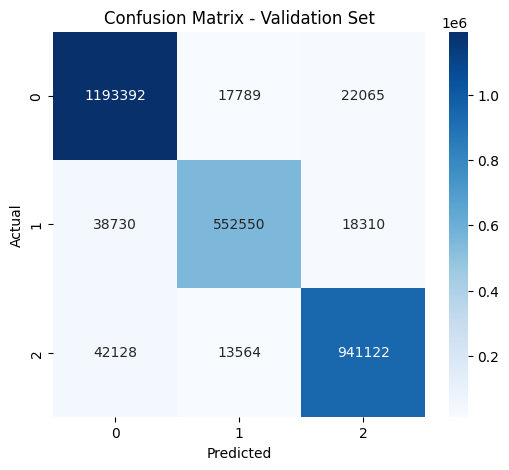


Per-class performance:
               precision    recall  f1-score       support
0              0.936545  0.967684  0.951860  1.233246e+06
1              0.946304  0.906429  0.925938  6.095900e+05
2              0.958864  0.944130  0.951440  9.968140e+05
accuracy       0.946266  0.946266  0.946266  9.462659e-01
macro avg      0.947238  0.939414  0.943079  2.839650e+06
weighted avg   0.946475  0.946266  0.946148  2.839650e+06

Total Misclassifications: 152586
Example misclassified indices (first 10): [ 14  20  22  33  63  93 100 113 128 138]

Misclassified counts by Actual Class:
 IncidentGrade
1    57040
2    55692
0    39854
Name: count, dtype: int64

Misclassified counts by Predicted Class:
 0    80858
2    40375
1    31353
Name: count, dtype: int64


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# 6. Error Analysis
# -------------------------
y_pred = random_search.best_estimator_.predict(X_val)

# Confusion Matrix Heatmap
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=best_model.classes_,
            yticklabels=best_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Validation Set")
plt.show()

# Per-class metrics
report_dict = classification_report(y_val, y_pred, output_dict=True)
class_wise_report = pd.DataFrame(report_dict).transpose()
print("\nPer-class performance:\n", class_wise_report)

# Misclassified samples
misclassified_idx = np.where(y_val != y_pred)[0]
print(f"\nTotal Misclassifications: {len(misclassified_idx)}")
print("Example misclassified indices (first 10):", misclassified_idx[:10])

# Distribution of misclassifications by actual class
misclassified_actual = y_val.iloc[misclassified_idx].value_counts()
print("\nMisclassified counts by Actual Class:\n", misclassified_actual)

# Distribution of misclassifications by predicted class
misclassified_pred = pd.Series(y_pred[misclassified_idx]).value_counts()
print("\nMisclassified counts by Predicted Class:\n", misclassified_pred)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# -------------------------
# Validation Error Analysis (no plots)
# -------------------------
y_pred = random_search.best_estimator_.predict(X_val)

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
print("\nConfusion Matrix (Validation Set):\n", cm)

# Classification Report as DataFrame
report_dict = classification_report(y_val, y_pred, output_dict=True)
class_wise_report = pd.DataFrame(report_dict).transpose()
print("\nPer-class Performance:\n", class_wise_report)

# Misclassified samples
misclassified_idx = np.where(y_val.values != y_pred)[0]
print(f"\nTotal Misclassifications: {len(misclassified_idx)}")
print("Example misclassified indices (first 10):", misclassified_idx[:10])

# Distribution of misclassifications by Actual Class
misclassified_actual = y_val.iloc[misclassified_idx].value_counts()
print("\nMisclassified counts by Actual Class:\n", misclassified_actual)

# Distribution of misclassifications by Predicted Class
misclassified_pred = pd.Series(y_pred[misclassified_idx]).value_counts()
print("\nMisclassified counts by Predicted Class:\n", misclassified_pred)



Confusion Matrix (Validation Set):
 [[1193392   17789   22065]
 [  38730  552550   18310]
 [  42128   13564  941122]]

Per-class Performance:
               precision    recall  f1-score       support
0              0.936545  0.967684  0.951860  1.233246e+06
1              0.946304  0.906429  0.925938  6.095900e+05
2              0.958864  0.944130  0.951440  9.968140e+05
accuracy       0.946266  0.946266  0.946266  9.462659e-01
macro avg      0.947238  0.939414  0.943079  2.839650e+06
weighted avg   0.946475  0.946266  0.946148  2.839650e+06

Total Misclassifications: 152586
Example misclassified indices (first 10): [ 14  20  22  33  63  93 100 113 128 138]

Misclassified counts by Actual Class:
 IncidentGrade
1    57040
2    55692
0    39854
Name: count, dtype: int64

Misclassified counts by Predicted Class:
 0    80858
2    40375
1    31353
Name: count, dtype: int64


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# -------------------------
# Validation Error Analysis (no plots)
# -------------------------
y_pred = XGB_model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix (Test Set):\n", cm)

# Classification Report as DataFrame
report_dict = classification_report(y_test, y_pred, output_dict=True)
class_wise_report = pd.DataFrame(report_dict).transpose()
print("\nPer-class Performance:\n", class_wise_report)

# Misclassified samples
misclassified_idx = np.where(y_test.values != y_pred)[0]
print(f"\nTotal Misclassifications: {len(misclassified_idx)}")
print("Example misclassified indices (first 10):", misclassified_idx[:10])

# Distribution of misclassifications by Actual Class
misclassified_actual = y_test.iloc[misclassified_idx].value_counts()
print("\nMisclassified counts by Actual Class:\n", misclassified_actual)

# Distribution of misclassifications by Predicted Class
misclassified_pred = pd.Series(y_pred[misclassified_idx]).value_counts()
print("\nMisclassified counts by Predicted Class:\n", misclassified_pred)



Confusion Matrix (Test Set):
 [[1629873   72736   50331]
 [  96467  755065   51166]
 [  84311   29054 1378989]]

Per-class Performance:
               precision    recall  f1-score       support
0              0.900159  0.929794  0.914736  1.752940e+06
1              0.881205  0.836454  0.858246  9.026980e+05
2              0.931443  0.924036  0.927725  1.492354e+06
accuracy       0.907409  0.907409  0.907409  9.074094e-01
macro avg      0.904269  0.896761  0.900236  4.147992e+06
weighted avg   0.907289  0.907409  0.907116  4.147992e+06

Total Misclassifications: 384065
Example misclassified indices (first 10): [ 0  2 10 11 14 19 25 38 40 63]

Misclassified counts by Actual Class:
 IncidentGrade
1    147633
0    123067
2    113365
Name: count, dtype: int64

Misclassified counts by Predicted Class:
 0    180778
1    101790
2    101497
Name: count, dtype: int64
